In [7]:
user = "admin"
passw = "AsH3saUzNX"
uri = "wheeliegood.cpd1upycyviv.us-east-1.rds.amazonaws.com"
# APIKEY = "faa0b3cb4ae90aba340567484b057e59c72b1a37"
APIKEY = "937848f62521aa822495dbe1716d5ca9ecf84fba"
NAME = "Dublin"
STATIONS = "https://api.jcdecaux.com/vls/v1/stations"
WEATHER_INFO = "https://api.openweathermap.org/data/2.5/weather"
FORECAST_INFO = "https://api.openweathermap.org/data/2.5/onecall"
FORECAST_API = "5cf5e19adac515b3f8510d2692fddc43"
WAPIKEY = "4f52f429445505a8554ffaf9b514990d"
WNAME = "2964574"
#https://api.openweathermap.org/data/2.5/onecall?lat=53.33306&lon=-6.24889&appid=5cf5e19adac515b3f8510d2692fddc43

In [8]:
from sqlalchemy import create_engine
from pandas import pandas as pd
from functools import lru_cache
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn import tree
import matplotlib.pyplot as plt
import pickle
import requests
import json
import numpy as np
import datetime

import warnings
warnings.filterwarnings('ignore')

In [9]:
def static_bikes():
    # Request Data from API
    engine = create_engine(f"mysql+mysqlconnector://{user}:{passw}@{uri}:3306/wheelieGood",
                           echo=True)
    # Using static bike table
    bike_data = pd.read_sql("SELECT * FROM wheelieGood.static_bikes;", engine)
    return bike_data

def dynamic_bikes():
    # Request Data from API
    engine = create_engine(f"mysql+mysqlconnector://{user}:{passw}@{uri}:3306/wheelieGood",
                           echo=True)
    # Using static bike table
    bike_data = pd.read_sql("SELECT * FROM wheelieGood.dynamic_bikes;", engine)
    return bike_data

def dynamic_weather():
    # Request Data from API
    engine = create_engine(f"mysql+mysqlconnector://{user}:{passw}@{uri}:3306/wheelieGood",
                           echo=True)
    # Using static bike table
    weather_data = pd.read_sql("SELECT * from weather", engine)
    return weather_data

### _Call the data from the database_

In [10]:
weather = dynamic_weather()
bikes = dynamic_bikes()
static = static_bikes()

2021-04-13 18:19:46,140 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-13 18:19:46,144 INFO sqlalchemy.engine.base.Engine {}
2021-04-13 18:19:46,481 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-13 18:19:46,481 INFO sqlalchemy.engine.base.Engine {}
2021-04-13 18:19:47,155 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-13 18:19:47,159 INFO sqlalchemy.engine.base.Engine {}
2021-04-13 18:19:47,827 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-13 18:19:47,827 INFO sqlalchemy.engine.base.Engine {}
2021-04-13 18:19:48,176 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-13 18:19:48,176 INFO sqlalchemy.engine.base.Engine {}
2021-04-13 18:19:48,627 INFO sqlalchemy.engine.base.Engine DESCRIBE `SELECT * from weather`
2021-04-13 18:19:48,627 INFO sqlalchemy.engine.base.Engine {}
2021-04-13 18:19:48,740 INFO sqla

### _Assess the data_

In [5]:
weather.dtypes

coord_lon                     float64
coord_lat                     float64
weather_main                   object
weather_description            object
weather_icon                   object
main_temp                     float64
main_pressure                   int64
main_humidity                   int64
main_temp_min                 float64
main_temp_max                 float64
visibility                      int64
wind_speed                    float64
wind_deg                        int64
clouds_all                      int64
dt                     datetime64[ns]
sys_type                        int64
sys_id                          int64
sys_country                    object
sys_sunrise            datetime64[ns]
sys_sunset             datetime64[ns]
city_id                         int64
city_name                      object
cod                             int64
Current Time           datetime64[ns]
dtype: object

In [6]:
print(weather.columns)
print(bikes.columns)
print(static.columns)

Index(['coord_lon', 'coord_lat', 'weather_main', 'weather_description',
       'weather_icon', 'main_temp', 'main_pressure', 'main_humidity',
       'main_temp_min', 'main_temp_max', 'visibility', 'wind_speed',
       'wind_deg', 'clouds_all', 'dt', 'sys_type', 'sys_id', 'sys_country',
       'sys_sunrise', 'sys_sunset', 'city_id', 'city_name', 'cod',
       'Current Time'],
      dtype='object')
Index(['number', 'available_bike_stands', 'available_bikes', 'last_update'], dtype='object')
Index(['number', 'name', 'address', 'pos_lat', 'pos_lng', 'bike_stands'], dtype='object')


### Data Modification

In [7]:
# Select columns containing categorical data
weather_categorical_columns = weather[['weather_description', 'weather_icon', 'sys_country']].columns

# Convert data type to category for these columns
for column in weather_categorical_columns:
    weather[column] = weather[column].astype('category')

In [8]:
weather_datetime_columns = weather[['Current Time', 'dt', 'sys_sunset', 'sys_sunrise']].columns

# Convert data type to datetime for these columns
for column in weather_datetime_columns:
    weather[column] = weather[column].astype('datetime64[ns]')

### Sort the data, pre-merge

In [9]:
bikes.sort_values('last_update', inplace=True)
weather.sort_values('dt', inplace=True)

### Trim the data set for the columns we want in our model

In [10]:
weatherTrim = weather[["weather_main", "wind_speed", "main_temp", "main_humidity", "dt"]]
weatherTrim.head(3)

,weather_main,wind_speed,main_temp,main_humidity,dt
0,Clouds,4.63,283.48,62,2021-03-08 13:37:42
1,Clouds,4.63,283.48,62,2021-03-08 13:38:36
3,Clouds,3.60,283.74,58,2021-03-08 13:51:36


### Add weather types to weather table (from api documentation)

Add these new columns to the dataframe. Initially set them to a value of zero, then change them where they match the weather_main column values to a 1. 

In [11]:
weatherConditions = ["Clouds", "Clear", "Snow", "Rain", "Drizzle", "Thunderstorm"]


weatherTrim = weatherTrim.reindex(weatherTrim.columns.tolist() + weatherConditions, axis=1)
for col in weatherConditions:
    weatherTrim[col] = weatherTrim[col].replace(np.nan).fillna(0)
    
weatherTrim.loc[(weatherTrim['weather_main'] == 'Clouds'), 'Clouds'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Clear'), 'Clear'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Snow'), 'Snow'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Rain'), 'Rain'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Drizzle'), 'Drizzle'] = 1
weatherTrim.loc[(weatherTrim['weather_main'] == 'Thunderstorm'), 'Thunderstorm'] = 1
weatherTrim.head(2)

,weather_main,wind_speed,main_temp,main_humidity,dt,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,Clouds,4.63,283.48,62,2021-03-08 13:37:42,1.0,0.0,0.0,0.0,0.0,0.0
1,Clouds,4.63,283.48,62,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0


### Weather main column is no longer needed

In [12]:
weatherTrim = weatherTrim.drop(columns="weather_main")
weatherTrim.head(2)

,wind_speed,main_temp,main_humidity,dt,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,4.63,283.48,62,2021-03-08 13:37:42,1.0,0.0,0.0,0.0,0.0,0.0
1,4.63,283.48,62,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
bikes.dtypes

number                            int64
available_bike_stands             int64
available_bikes                   int64
last_update              datetime64[ns]
dtype: object

In [14]:
weatherTrim.dtypes

wind_speed              float64
main_temp               float64
main_humidity             int64
dt               datetime64[ns]
Clouds                  float64
Clear                   float64
Snow                    float64
Rain                    float64
Drizzle                 float64
Thunderstorm            float64
dtype: object

### _Merge the weather and bikes data sets on closest matching datetimes_

In [16]:
merged_data = pd.merge_asof(bikes, weatherTrim, left_on="last_update", right_on="dt")

In [17]:
#for inspection
#merged_data.to_csv("mergeddf.csv")

In [18]:
bikes.shape

(1102372, 4)

In [19]:
merged_data.shape

(1102372, 14)

An apparent issue with the first 20 rows in the df. They will be dropped. The data set is 997732 rows long at the time of this decision, so 20 is not a concern.

In [20]:
#merged_data.head(25)

In [188]:
data = merged_data.loc[20:684575]
data.head(2)

,number,available_bike_stands,available_bikes,last_update,wind_speed,main_temp,main_humidity,dt,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
20,5,20,20,2021-03-08 13:40:07,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0
21,89,26,14,2021-03-08 13:42:06,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0


In [189]:
# Create new column weekday
data['weekday'] = data['last_update'].dt.dayofweek
# Create new column hour
data['hour'] = data['last_update'].dt.hour
data.nunique()

number                      110
available_bike_stands        41
available_bikes              41
last_update              281954
wind_speed                   27
main_temp                  1001
main_humidity                24
dt                         4609
Clouds                        2
Clear                         2
Snow                          1
Rain                          2
Drizzle                       2
Thunderstorm                  1
weekday                       7
hour                         24
dtype: int64

In [190]:
data.head(2)

,number,available_bike_stands,available_bikes,last_update,wind_speed,main_temp,main_humidity,dt,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm,weekday,hour
20,5,20,20,2021-03-08 13:40:07,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0,0,13
21,89,26,14,2021-03-08 13:42:06,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0,0,13


### _Investigate prevelance of 0 values for available bikes in the data set_

Upon creation of the models, we noticed that there were a number of stations returning a lot of 0s. 

In [191]:
stations = []
bikesZeroPercentages = []

for value in bikes["number"].unique():
    stations.append(value)

for station in stations:
    bikesZero = bikes[(bikes["number"] == station) & (bikes["available_bikes"] == 0)]
    allRows = bikes[bikes["number"] == station]
    
    numNoBikes  = bikesZero["number"].count()
    numAllRows = allRows["number"].count()
    
    percentage = round((numNoBikes/numAllRows)*100, 2)
    bikesZeroPercentages.append(percentage)
        
print(bikesZeroPercentages)

[10.13, 3.75, 2.16, 4.05, 3.13, 4.97, 4.1, 0.15, 2.7, 9.43, 1.63, 4.11, 2.28, 1.96, 12.79, 0.27, 1.24, 8.82, 0.5, 7.72, 3.72, 6.58, 1.44, 2.6, 3.31, 1.66, 3.22, 8.66, 3.3, 31.56, 2.36, 2.99, 5.49, 2.8, 1.76, 6.51, 5.92, 1.69, 3.5, 3.01, 1.26, 0.8, 2.76, 1.9, 2.02, 0.92, 1.57, 8.54, 2.06, 4.48, 1.54, 7.6, 1.58, 1.64, 7.17, 3.19, 7.05, 1.33, 2.99, 17.06, 3.21, 4.1, 6.65, 28.02, 1.69, 23.8, 1.23, 0.76, 3.06, 1.64, 2.45, 4.63, 25.76, 2.68, 3.81, 11.5, 5.39, 4.51, 4.4, 1.03, 10.64, 3.97, 2.94, 1.4, 3.09, 1.41, 1.92, 1.59, 4.33, 0.54, 1.46, 1.3, 1.78, 2.16, 6.5, 4.81, 1.22, 1.4, 6.24, 1.34, 21.09, 2.99, 3.42, 5.75, 3.14, 7.44, 2.28, 3.81, 2.95, 9.67]


### _Certain stations are returning very large percentages of their data as zero bikes. Will cautiously purge these until they are closer to the date set average._

Let's see the average zero returns

In [192]:
percZeroList = []
largePercZero = []
total = 0
for station in stations:
    for day in range(0, 7):
        dayAndStation = data[(data["number"] == station) & (data["weekday"] == day)]
        zeroBikes = dayAndStation[dayAndStation["available_bikes"] == 0]
        
        x = dayAndStation["available_bikes"].shape[0]
        y = zeroBikes["available_bikes"].shape[0]
        if y > 0:
            percentZero = (y/x)*100
        else:
            percentZero = 0
            
        if percentZero > 15:
            largePercZero.append((station, day))
        percZeroList.append(percentZero)
        total += percentZero

average = total/len(percZeroList)
print(f"Data frame 0 bikes average: {average}")

Data frame 0 bikes average: 5.607877220692098


In [193]:
# print days/stations where zero values exceeds 20%
print(largePercZero)

[(3, 2), (33, 6), (100, 6), (25, 4), (25, 5), (59, 6), (84, 6), (103, 6), (54, 0), (54, 6), (39, 6), (52, 6), (89, 2), (107, 6), (71, 6), (105, 6), (117, 0), (117, 1), (117, 3), (117, 4), (117, 5), (117, 6), (97, 6), (114, 3), (114, 5), (2, 3), (2, 6), (79, 4), (37, 6), (85, 6), (21, 1), (21, 2), (21, 6), (86, 6), (102, 0), (102, 6), (104, 6), (53, 5), (36, 6), (80, 3), (80, 4), (80, 5), (9, 0), (9, 1), (9, 2), (9, 3), (9, 6), (45, 6), (6, 0), (6, 3), (6, 5), (6, 6), (98, 0), (98, 1), (98, 2), (98, 3), (98, 5), (98, 6), (95, 6), (116, 6), (27, 0), (27, 1), (27, 3), (27, 4), (27, 5), (27, 6), (17, 0), (17, 6), (93, 1), (15, 2), (62, 3), (62, 4), (62, 6), (57, 6), (82, 6), (19, 3), (77, 6), (94, 4), (30, 0), (30, 3), (30, 4), (30, 5), (30, 6), (65, 3), (7, 4), (7, 6), (507, 4)]


### _Clean the data set of excess zero values_

In [194]:
for x in range(len(largePercZero)):
    current = largePercZero[x]
    values = (data[(data["number"] == current[0]) & 
                     (data["available_bikes"] == 0) & 
                     (data["weekday"] == current[1])]).sample(frac=.5).index
    print
    
    data.drop(values, inplace=True)
print(data[data["available_bikes"]==0].shape)
print(data.shape)

(29371, 16)
(675860, 16)


### We should have a small decrease in zero percentages

In [195]:
print((27939/579693)*100)
print((25456/577210)*100)

4.8196200402626905
4.410180003811438


In [197]:
percZeroList = []
largePercZero = []
total = 0
for station in stations:
    for day in range(0, 7):
        dayAndStation = data[(data["number"] == station) & (data["weekday"] == day)]
        zeroBikes = dayAndStation[dayAndStation["available_bikes"] == 0]
        
        x = dayAndStation["available_bikes"].shape[0]
        y = zeroBikes["available_bikes"].shape[0]
        if y > 0:
            percentZero = (y/x)*100
        else:
            percentZero = 0
            
        if percentZero > 15:
            largePercZero.append((station, day))
            
        percZeroList.append(percentZero)
        total += percentZero
print(largePercZero)

[(54, 6), (117, 0), (117, 3), (117, 4), (117, 6), (21, 1), (6, 3), (6, 5), (6, 6), (98, 3), (98, 5), (98, 6), (27, 0), (27, 1), (27, 6), (17, 6), (62, 4), (30, 0), (30, 4), (30, 5), (30, 6), (65, 3)]


### _Build and test initial models_

There is a choice made here to build and test the initial models on only one output column. This is because the accuracy score test does not support multi-ouput. It is probable that the final model will be dual output (available bikes and available bike stands). 

However, this may also be achieved through a calculation using df data.

In [198]:
# X for the input data to be predicted on
X = data.drop(columns = ["available_bikes", "available_bike_stands", "last_update", "dt"])
# y for the out/goal set
y = data[["available_bikes"]]

In [199]:
X.head(0)

,number,wind_speed,main_temp,main_humidity,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm,weekday,hour


### _Divide into training and testing set, and test for accuracy_

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

### _Decision Tree Model_

In [201]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train, y_train)
predictions = decisionTree.predict(X_test)
score = accuracy_score(y_test, predictions)
print(f"Accuracy: {score}")

Accuracy: 0.847327848962803


### Test sample predictions

In [202]:
# give test predictor the stand number, the wind speed, the main temp (kelvin) 
# the humidity, the weekday number, and the hour of the day
prediction = decisionTree.predict([[25, 40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
prediction_values = prediction[0]
print(f"Predicted bikes available: {prediction_values}")

Predicted bikes available: 12


## _Random Forest_

In [204]:
randForestModel = RandomForestClassifier(n_estimators = 10, random_state=10)
randForestModel.fit(X_train, y_train.values.ravel())
forestPrediction = randForestModel.predict([[12, 40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
forestPrediction

array([11], dtype=int64)

### Test accuracy

In [205]:
predictionTest = randForestModel.predict(X_test)
forestScore = accuracy_score(y_test, predictionTest)
forestScore

0.746796673867369

### Result is unexpectedly lower than that for decision tree
This is unintuitive.
I cannot increase the number of estimators as the pickle file will be too large for github. 
Will need to look at this further

### Check feature importances

In [206]:
feature_list = list(X.columns)
feature_imp = pd.Series(randForestModel.feature_importances_, index=feature_list)
feature_imp.sort_values(ascending=False)

number           0.844660
main_temp        0.071941
hour             0.031966
wind_speed       0.022638
weekday          0.015199
main_humidity    0.010314
Clouds           0.001345
Rain             0.000987
Clear            0.000725
Drizzle          0.000226
Snow             0.000000
Thunderstorm     0.000000
dtype: float64

## K-Nearest Neighbour

In [210]:
knn_model = KNeighborsClassifier(n_neighbors = 10)
knn_model.fit(X_train, y_train.values.ravel())
knn_prediction = knn_model.predict([[12, 40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
knn_prediction

array([11], dtype=int64)

In [211]:
knnTest = knn_model.predict(X_test)
knnScore = accuracy_score(y_test, knnTest)
knnScore

0.6002574497677033

### Knn model is even less accurate. Discarding as option.

## Linear Regression

### Linear regression is a possible option, but it will be discounted as we desire to predict a number of bikes per stand.

In [213]:
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
linear_prediction = linearModel.predict([[12, 40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
linear_prediction

array([[1.23044069]])

## _A model per station_

### _Let's re-assess accuracy of our models if we look at per station basis._ 

In [214]:
# let's take only station 12
station = data[data["number"]== 12]
X = station.drop(columns= ["number", "available_bikes", "available_bike_stands", "last_update", "dt"])
y = station[["available_bikes"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

- Note: Num of estimators needed to peak at 9, for file size reasons

In [215]:
randForestModel = RandomForestClassifier(n_estimators = 8, random_state=20)
randForestModel.fit(X_train, y_train.values.ravel())
forestPrediction = randForestModel.predict([[40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
forestPrediction

array([5], dtype=int64)

In [216]:
predictions = randForestModel.predict(X_test)
accuracy_score(y_test, predictions)

0.850996015936255

### The is a significant improvement, but we should check decision tree again, and more than one station.

### Let's check multiple stations at random

In [218]:
stationsList = data["number"].unique().tolist()
sortedStations = sorted(stationsList)

In [219]:
RF_accuracy = []
DT_accuracy = []

for station in sortedStations:
    station = data[data["number"]== station]
    X = station.drop(columns= ["number", "available_bikes", "available_bike_stands", "last_update", "dt"])
    y = station[["available_bikes"]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    
    decisionTree = DecisionTreeClassifier()
    decisionTree.fit(X_train, y_train)
    predictions = decisionTree.predict(X_test)
    DT_score = accuracy_score(y_test, predictions)
    DT_accuracy.append(DT_score)
    
    randForestModel = RandomForestClassifier(n_estimators = 8, random_state=20)
    randForestModel.fit(X_train, y_train.values.ravel())
    forestPrediction = randForestModel.predict([[40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
    predictions = randForestModel.predict(X_test)
    RF_score = accuracy_score(y_test, predictions)
    RF_accuracy.append(RF_score)

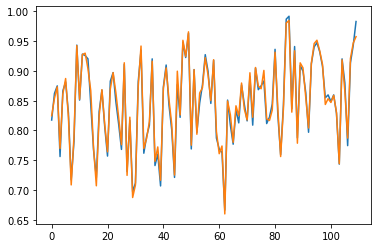

In [220]:
plt.plot(RF_accuracy)
plt.plot(DT_accuracy)

- There appears to be a near identical accuracy from both methods. 

### _Let's create a model for every station_
We will use random forest to make a model for each station for hourly available data, and one for when our hourly forecast limit is exceeded.

### Daily Models

In [229]:
data.head(2)

,number,available_bike_stands,available_bikes,last_update,wind_speed,main_temp,main_humidity,dt,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm,weekday,hour
20,5,20,20,2021-03-08 13:40:07,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0,0,13
21,89,26,14,2021-03-08 13:42:06,4.63,283.48,62.0,2021-03-08 13:38:36,1.0,0.0,0.0,0.0,0.0,0.0,0,13


In [230]:
for x in data.number.unique():
    station = data[data["number"] == x]
    X = station.drop(columns= ["number", "hour", "available_bikes", "available_bike_stands", "last_update", "dt"])
    y = station[["available_bike_stands"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    randForestModel = RandomForestClassifier(n_estimators = 9, random_state=20)
    randForestModel.fit(X, y.values.ravel())
    forestPrediction = randForestModel.predict([[40, 300, 80, 1, 0, 0, 0, 0, 0, 6]])
    pickle.dump(randForestModel, open(f'pickle_jar/dailyModels/randForest{x}.pkl','wb'))

In [232]:
for x in data.number.unique():
    station = data[data["number"]== x]
    X = station.drop(columns= ["number", "available_bikes", "available_bike_stands", "last_update", "dt"])
    y = station[["available_bikes"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    randForestModel = RandomForestClassifier(n_estimators = 9, random_state=20)
    randForestModel.fit(X_train, y_train.values.ravel())
    forestPrediction = randForestModel.predict([[40, 300, 80, 1, 0, 0, 0, 0, 0, 6, 20]])
    pickle.dump(randForestModel, open(f'pickle_jar/hourlyModels/randForest{x}.pkl','wb'))

# 2. _Take incoming data and format to meet model requirements_

In [32]:
forecast = requests.get("https://api.openweathermap.org/data/2.5/onecall?lat=53.33306&lon=-6.24889&exclude=current,minutely&appid=5cf5e19adac515b3f8510d2692fddc43")
forecast

<Response [200]>

In [36]:
forecast_data = forecast.json()

In [37]:
# iterate over the json array to get the hourly data
hourly_data = 0
for k, v in forecast_data.items():
    if k == "hourly":
        hourly_data = v

# for x in range(len(hourly_data)):
#     hourly_data[x]
print(type(hourly_data))

<class 'list'>


In [38]:
# convert the hourly data to a dataframe
df = pd.DataFrame.from_dict(pd.json_normalize(hourly_data), orient='columns')
df.head(2)

,dt,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,weather,pop
0,1618347600,278.69,278.69,1032,75,274.62,0.0,40,10000,1.09,232,1.04,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.01
1,1618351200,278.59,278.59,1032,77,274.89,0.0,37,10000,1.24,241,1.22,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.00


### Create a list of weather values that corresponds with the value in the inner array per row

In [39]:
weatherValues = []
for x in df["weather"]:
    currentRow = x[0]
    for key, value in currentRow.items():
        if key == "main":
            weatherValues.append(value)
            
print(weatherValues)

['Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clear', 'Clear', 'Clear', 'Clear', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clouds', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds', 'Clouds']


### As we did before, create rows that correspond to these values

In [48]:
weatherConditions = ["Clouds", "Clear", "Snow", "Rain", "Drizzle", "Thunderstorm"]
df = df.reindex(df.columns.tolist() + weatherConditions, axis=1)
for col in df:
    df[col] = df[col].replace(np.nan).fillna(0)
df.head(2)

,dt,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,weather,pop,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,1618347600,278.69,278.69,1032,75,274.62,0.0,40,10000,1.09,232,1.04,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.01,0.0,0.0,0.0,0.0,0.0,0.0
1,1618351200,278.59,278.59,1032,77,274.89,0.0,37,10000,1.24,241,1.22,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
for x in range(len(weatherValues)):
    for column in df.columns:
        if weatherValues[x] == column:
            df.at[x, column] = 1
df.head(2)

,dt,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,weather,pop,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,1618347600,278.69,278.69,1032,75,274.62,0.0,40,10000,1.09,232,1.04,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.01,1.0,0.0,0.0,0.0,0.0,0.0
1,1618351200,278.59,278.59,1032,77,274.89,0.0,37,10000,1.24,241,1.22,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.00,1.0,0.0,0.0,0.0,0.0,0.0


### Dump un-needed columns

In [55]:
# get rid of the unneeded rows
weather_df = df[["dt", "temp", "wind_speed", "humidity", "Clouds", "Clear", "Snow", "Rain", "Drizzle", "Thunderstorm"]]
weather_df.head(2)

,dt,temp,wind_speed,humidity,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,1618347600,278.69,1.09,75,1.0,0.0,0.0,0.0,0.0,0.0
1,1618351200,278.59,1.24,77,1.0,0.0,0.0,0.0,0.0,0.0


In [56]:
df.dtypes

dt                int64
temp            float64
feels_like      float64
pressure          int64
humidity          int64
dew_point       float64
uvi             float64
clouds            int64
visibility        int64
wind_speed      float64
wind_deg          int64
wind_gust       float64
weather          object
pop             float64
Clouds          float64
Clear           float64
Snow            float64
Rain            float64
Drizzle         float64
Thunderstorm    float64
dtype: object

In [57]:
# convert from unix epoch time to useable format...
from datetime import datetime, timedelta
start = datetime(1970, 1, 1)  # Unix epoch start time
weather_df['dt'] = weather_df.dt.apply(lambda x: start + timedelta(seconds=x))

In [58]:
weather_df.head(2)

,dt,temp,wind_speed,humidity,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,2021-04-13 21:00:00,278.69,1.09,75,1.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-13 22:00:00,278.59,1.24,77,1.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Create new column weekday
weather_df['weekday'] = weather_df['dt'].dt.dayofweek
# Create new column hour
weather_df['hour'] = weather_df['dt'].dt.hour

# dump now defunct datetime column
weather_df = weather_df.drop(columns= ["dt"])

In [60]:
weather_df.head(20)

,temp,wind_speed,humidity,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm,weekday,hour
0,278.69,1.09,75,1.0,0.0,0.0,0.0,0.0,0.0,1,21
1,278.59,1.24,77,1.0,0.0,0.0,0.0,0.0,0.0,1,22
2,278.35,1.10,79,1.0,0.0,0.0,0.0,0.0,0.0,1,23
3,277.88,1.02,81,1.0,0.0,0.0,0.0,0.0,0.0,2,0
4,277.40,1.06,83,1.0,0.0,0.0,0.0,0.0,0.0,2,1
5,276.95,0.92,86,0.0,1.0,0.0,0.0,0.0,0.0,2,2
6,276.75,0.80,86,0.0,1.0,0.0,0.0,0.0,0.0,2,3
7,276.55,0.48,87,0.0,1.0,0.0,0.0,0.0,0.0,2,4
8,276.58,0.30,88,0.0,1.0,0.0,0.0,0.0,0.0,2,5
9,277.05,0.58,89,1.0,0.0,0.0,0.0,0.0,0.0,2,6


In [61]:
weather_df.nunique()

temp            46
wind_speed      44
humidity        27
Clouds           2
Clear            2
Snow             1
Rain             1
Drizzle          1
Thunderstorm     1
weekday          3
hour            24
dtype: int64

In [62]:
weather_df.shape

(48, 11)

## Create a dummy weather data set and insert a station number at the first index

In [81]:
desired_row = df.iloc[1]
weather_details = desired_row["weather"][0]

for key, value in weather_details.items():
    if key == "icon":
        icon = value

03n


In [87]:
df.head(0)

,dt,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,weather,pop,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm


In [85]:
desired_row = df[(df["hour"] == hour) & (df["weekday"] == day)]

KeyError: 'hour'

In [84]:
#insert station number
desired_row = weather_df.iloc[1].tolist()
desired_row.insert(0, 12)
desired_row.append(icon)
desired_row[0:12]

[12, 278.59, 1.24, 77.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 22.0]

In [ ]:
# give test predictor the list of user input variables (in this case, a dummy set)
prediction = model.predict([desired_row])
prediction_values = prediction[0]

#sample output
print(f"Station number {desired_row[0]}")
print("-------------------")
print(f"Predicted available bikes at  : {prediction_values[0]} ")
print(f"Predicted available bike stands : {prediction_values[1]}")

# Formatting Static Bikes info

In [24]:
static.head(0)

,number,name,address,pos_lat,pos_lng,bike_stands


In [23]:
desired = static[static["number"]==42]
desired_list = list(desired.values)
formatted_list = (desired_list[0])
print(formatted_list)

[42 'SMITHFIELD NORTH' 'Smithfield North' 53.3496 -6.2782 30]


In [31]:
listed = [1, 2, 4]

listed.extend((formatted_list[5], formatted_list[1]))
listed

[1, 2, 4, 30, 'SMITHFIELD NORTH']

In [89]:
mine = [[283.16, 2.55, 64, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, '03d', 2, 10]]
mine[0][9]

'03d'

In [94]:
test = [283.16, 2.55, 64, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2, 10, '03d']
print(test[0:11])

[283.16, 2.55, 64, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2, 10]


In [96]:
test[11]

'03d'

In [102]:
df = df.rename(columns = {'temp':'test'})
df

,dt,test,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,weather,pop,Clouds,Clear,Snow,Rain,Drizzle,Thunderstorm
0,1618347600,278.69,278.69,1032,75,274.62,0.00,40,10000,1.09,232,1.04,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.01,1.0,0.0,0.0,0.0,0.0,0.0
1,1618351200,278.59,278.59,1032,77,274.89,0.00,37,10000,1.24,241,1.22,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.00,1.0,0.0,0.0,0.0,0.0,0.0
2,1618354800,278.35,278.35,1033,79,275.01,0.00,35,10000,1.10,251,1.21,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.00,1.0,0.0,0.0,0.0,0.0,0.0
3,1618358400,277.88,277.88,1033,81,274.90,0.00,31,10000,1.02,249,1.14,"[{'id': 802, 'main': 'Clouds', 'description': ...",0.00,1.0,0.0,0.0,0.0,0.0,0.0
4,1618362000,277.40,277.40,1033,83,274.77,0.00,16,10000,1.06,240,1.11,"[{'id': 801, 'main': 'Clouds', 'description': ...",0.00,1.0,0.0,0.0,0.0,0.0,0.0
5,1618365600,276.95,276.95,1033,86,274.26,0.00,9,10000,0.92,234,1.02,"[{'id': 800, 'main': 'Clear', 'description': '...",0.00,0.0,1.0,0.0,0.0,0.0,0.0
6,1618369200,276.75,276.75,1033,86,274.20,0.00,9,10000,0.80,241,0.97,"[{'id': 800, 'main': 'Clear', 'description': '...",0.00,0.0,1.0,0.0,0.0,0.0,0.0
7,1618372800,276.55,276.55,1033,87,274.19,0.00,9,10000,0.48,238,0.77,"[{'id': 800, 'main': 'Clear', 'description': '...",0.00,0.0,1.0,0.0,0.0,0.0,0.0
8,1618376400,276.58,276.58,1033,88,274.32,0.00,10,10000,0.30,127,0.58,"[{'id': 800, 'main': 'Clear', 'description': '...",0.00,0.0,1.0,0.0,0.0,0.0,0.0
9,1618380000,277.05,277.05,1034,89,274.85,0.00,13,10000,0.58,145,0.74,"[{'id': 801, 'main': 'Clouds', 'description': ...",0.00,1.0,0.0,0.0,0.0,0.0,0.0
